# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 1, #number of variables
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0.5,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': True,
        'nas_type': 'SEQUENTIAL', #options:(None, 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
sys.path.append('..')

from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [6]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis

config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else 2*config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_6_drop0.25e500b512_custom/lnets_10000_30-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_1_d_5_sparsity_6_amin_-1_amax_1_xdist_uniform_noise_normal_0.5
lnets_10000_30-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_1_d_5_sparsity_6_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0.5


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/weights_' + '_epoch_' + str(index).zfill(3) + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 out of   1 | elapsed:  5.3min finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
6252,1373158606,0.924,0.492,-0.142,-0.402,-0.741,0.255,0.928,0.188,3.546,-14.970,17.958,-7.092,0.928,0.188,3.546,-14.970,17.958,-7.092,-0.009,-0.227,0.344,0.271,0.204,0.140,0.331,-0.297,0.252,0.120,0.473,-0.088,-0.019,0.361,0.129,0.449,-0.004,0.241,0.297,0.265,-0.001,0.230,0.009,-0.042,-0.404,-0.090,0.232,-0.291,-0.209,-0.233,0.000,0.000,-0.114,-0.083,0.224,0.225,-0.116,0.000,-0.080,0.305,-0.111,0.000,0.000,-0.122,0.235,-0.114,0.223,0.246,0.217,0.234,0.285,-0.088,-0.022,0.000,0.000,0.000,-0.082,0.000,0.000,0.000,-0.254,-0.359,-0.409,-0.447,0.351,0.407,-0.264,-0.408,-0.499,0.126,-0.249,-0.352,-0.364,-0.266,0.348,-0.329,0.688,0.226,0.362,0.256,0.337,-0.619,-0.045,-0.261,-0.383,-0.059,-0.622,0.144,-0.258,-0.315,0.192
4684,1373158606,-0.794,0.241,-0.127,-0.188,-0.535,-0.939,-0.448,-1.093,-0.299,1.114,-1.272,0.497,-0.448,-1.093,-0.299,1.114,-1.272,0.497,-0.009,-0.227,0.382,0.276,0.155,0.092,0.343,-0.297,0.243,0.424,0.509,-0.088,-0.019,0.388,0.090,0.491,0.008,0.214,0.239,0.224,0.033,0.190,0.145,-0.042,-0.404,-0.090,0.202,-0.291,-0.209,-0.233,0.000,0.000,0.097,0.097,-0.073,-0.072,0.102,0.000,0.097,0.122,0.100,0.000,0.000,0.101,-0.070,0.098,-0.023,-0.065,-0.077,-0.071,-0.040,0.096,0.112,0.000,0.000,0.000,0.096,0.000,0.000,0.000,-0.254,-0.359,-0.399,-0.396,0.149,0.188,-0.240,-0.408,-0.421,-0.129,-0.264,-0.352,-0.364,-0.257,0.122,-0.340,0.393,0.026,0.183,0.066,0.049,-0.463,-0.192,-0.261,-0.383,-0.059,-0.490,0.144,-0.258,-0.315,-0.091
1731,1373158606,-0.739,0.951,0.737,0.786,0.773,0.083,-0.473,0.326,-5.952,27.597,-29.912,10.561,-0.473,0.326,-5.952,27.597,-29.912,10.561,-0.009,-0.227,0.142,0.087,0.662,0.578,0.123,-0.297,0.069,0.882,0.409,-0.088,-0.019,0.146,0.595,0.231,0.427,0.781,0.754,0.773,0.563,0.041,0.007,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.146,-0.095,-0.229,-0.263,-0.124,0.000,-0.080,-0.244,-0.226,0.000,0.000,-0.147,-0.270,-0.128,-0.233,-0.197,-0.179,-0.194,-0.291,-0.054,-0.025,0.000,0.000,0.000,-0.060,0.000,0.000,0.000,-0.254,-0.359,-0.189,-0.222,0.699,0.759,-0.033,-0.408,-0.255,0.487,0.199,-0.352,-0.364,-0.021,0.700,0.072,1.060,0.576,0.711,0.606,0.691,-0.308,-0.043,-0.261,-0.383,-0.059,-0.332,0.144,-0.258,-0.315,-0.470
4742,1373158606,0.173,-0.607,-0.085,0.746,-0.828,-0.939,0.120,0.799,-7.836,20.337,-25.362,10.857,0.120,0.799,-7.836,20.337,-25.362,10.857,-0.009,-0.227,0.451,0.360,0.102,0.035,0.376,-0.297,0.342,0.483,0.579,-0.088,-0.019,0.464,0.048,0.559,0.007,0.244,0.184,0.196,0.030,0.310,0.329,-0.042,-0.404,-0.090,0.317,-0.291,-0.209,-0.233,0.000,0.000,-0.065,-0.216,0.061,0.020,-0.191,0.000,-0.205,-0.187,-0.084,0.000,0.000,-0.066,0.009,-0.081,-0.025,0.007,0.082,0.048,-0.041,-0.185,-0.196,0.000,0.000,0.000,-0.189,0.000,0.000,0.000,-0.254,-0.359,-0.474,-0.635,0.101,0.113,-0.337,-0.408,-0.695,-0.218,-0.335,-0.352,-0.364,-0.333,0.039,-0.411,0.393,-0.050,0.141,0.012,0.046,-0.798,-0.676,-0.261,-0.383,-0.059,-0.810,0.144,-0.258,-0.315,0.113
4521,1373158606,0.131,0.208,0.871,0.323,0.573,0.164,0.111,-0.058,2.347,-4.308,8.729,-4.877,0.111,-0.058,2.347,-4.308,8.729,-4.877,-0.009,-0.227,0.129,0.083,0.582,0.491,0.110,-0.297,0.068,0.822,0.366,-0.088,-0.019,0.257,0.506,0.240,0.329,0.641,0.663,0.656,0.493,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,1373158606.000,0.001,-0.005,-0.000,0.004,-0.003,-0.003,0.000,0.031,-0.199,0.417,-0.388,0.130,0.000,0.031,-0.199,0.417,-0.388,0.130,-0.009,-0.227,0.279,0.183,0.278,0.218,0.250,-0.297,0.155,0.416,0.423,-0.088,-0.019,0.294,0.218,0.388,0.081,0.355,0.361,0.358,0.142,0.108,0.054,-0.042,-0.404,-0.090,0.119,-0.291,-0.209,-0.233,0.000,0.000,-0.004,-0.003,0.010,0.010,-0.011,0.000,-0.001,-0.004,-0.012,0.000,0.000,-0.010,0.009,-0.002,0.026,-0.004,0.013,0.004,0.019,0.005,0.022,0.000,0.000,0.000,0.003,0.000,0.000,0.000,-0.254,-0.359,-0.330,-0.352,0.304,0.350,-0.173,-0.408,-0.387,0.007,-0.156,-0.352,-0.364,-0.177,0.287,-0.252,0.556,0.155,0.328,0.197,0.229,-0.444,-0.183,-0.261,-0.383,-0.059,-0.467,0.144,-0.258,-0.315,0.003
std,0.000,0.574,0.577,0.577,0.577,0.575,0.580,0.486,0.901,4.247,11.168,13.408,5.653,0.486,0.901,4.247,11.168,13.408,5.653,0.000,0.000,0.120,0.115,0.132,0.129,0.121,0.000,0.114,0.174,0.123,0.000,0.000,0.120,0.134,0.121,0.121,0.145,0.132,0.137,0.154,0.113,0.138,0.000,0.000,0.000,0.112,0.000,0.000,0.000,0.000,0.000,0.113,0.111,0.122,0.122,0.121,0.000,0.109,0.185,0.126,0.000,0.000,0.120,0.127,0.114,0.106,0.147,0.116,0.133,0.139,0.105,0.121,0.000,0.000,0.000,0.105,0.000,0.000,0.000,0.000,0.000,0.119,0.132,0.135,0.143,0.154,0.000,0.140,0.235,0.206,0.000,0.000,0.161,0.148,0.137,0.180,0.230,0.130,0.201,0.183,0.158,0.191,0.000,0.000,0.000,0.153,0.000,0.000,0.000,0.124
min,1373158606.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.173,-3.739,-26.808,-68.651,-81.859,-36.964,-1.173,-3.739,-26.808,-68.651,-81.859,-36.964,-0.009,-0.227,-0.100,-0.258,-0.123,-0.230,-0.120,-0.297,-0.280,-0.060,0.152,-0.088,-0.019,-0.042,-0.244,0.070,-0.288,-0.063,0.005,-0.029,-0.380,-0.327,-0.385,-0.042,-0.404,-0.090,-0.312,-0.291,-0.209,-0.233,0.000,0.000,-0.390,-0.390,-0.406,-0.440,-0.587,0.000,-0.376,-0.832,-0.904,0.000,0.000,-0.662,-0.471,-0.615,-0.376,-0.744,-0.371,-0.656,-0.555,-0.361,-0.483,0.000,0.000,0.000,-0.359,0.000,0.000,0.000,-0.254,-0.359,-0.943,-1.196,0.011,0.106,-1.008,-0.408,-1.295,-1.134,-0.760,-0.352,-0.364,-0.877,0.030,-0.831,0.338,-2.004,-0.009,-1.781,-0.545,-1.508,-1.561,-0.261,-0.38

## Generate Datasets for Interpretation-Net training

In [14]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [15]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8100, 110)

In [16]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 110)

In [17]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(1000, 110)

In [18]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
3003,1373158606,-0.340,-0.876,-0.048,-0.460,0.430,0.914,-0.402,-0.718,0.232,-0.009,0.204,-0.191,-0.402,-0.718,0.232,-0.009,0.204,-0.191,-0.009,-0.227,0.303,0.197,0.206,0.165,0.258,-0.297,0.164,0.320,0.427,-0.088,-0.019,0.305,0.164,0.412,0.009,0.276,0.310,0.290,0.128,0.111,0.043,-0.042,-0.404,-0.090,0.123,-0.291,-0.209,-0.233,0.000,0.000,0.100,0.100,-0.110,-0.091,0.105,0.000,0.100,0.127,0.103,0.000,0.000,0.104,-0.090,0.100,-0.023,-0.067,-0.073,-0.070,-0.068,0.100,0.120,0.000,0.000,0.000,0.100,0.000,0.000,0.000,-0.254,-0.359,-0.340,-0.342,0.242,0.296,-0.183,-0.408,-0.370,-0.071,-0.201,-0.352,-0.364,-0.198,0.231,-0.278,0.394,0.109,0.265,0.148,0.203,-0.419,-0.167,-0.261,-0.383,-0.059,-0.444,0.144,-0.258,-0.315,-0.094
5985,1373158606,-0.496,-0.607,0.252,0.645,-0.276,-0.135,-0.421,-0.888,2.268,-3.903,3.177,-0.989,-0.421,-0.888,2.268,-3.903,3.177,-0.989,-0.009,-0.227,0.289,0.182,0.246,0.188,0.242,-0.297,0.149,0.300,0.412,-0.088,-0.019,0.290,0.185,0.397,0.009,0.293,0.327,0.308,0.118,0.096,0.021,-0.042,-0.404,-0.090,0.109,-0.291,-0.209,-0.233,0.000,0.000,0.106,0.107,-0.040,-0.032,0.112,0.000,0.107,0.133,0.109,0.000,0.000,0.110,-0.030,0.106,-0.022,-0.047,-0.052,-0.049,-0.020,0.107,0.133,0.000,0.000,0.000,0.107,0.000,0.000,0.000,-0.254,-0.359,-0.333,-0.339,0.238,0.272,-0.178,-0.408,-0.368,-0.065,-0.192,-0.352,-0.364,-0.191,0.207,-0.270,0.394,0.118,0.274,0.157,0.134,-0.421,-0.182,-0.261,-0.383,-0.059,-0.445,0.144,-0.258,-0.315,-0.101
6925,1373158606,-0.316,0.287,0.323,-0.293,-0.713,0.105,-0.072,-0.586,1.097,-2.294,2.186,-0.775,-0.072,-0.586,1.097,-2.294,2.186,-0.775,-0.009,-0.227,0.303,0.197,0.217,0.155,0.259,-0.297,0.164,0.321,0.427,-0.088,-0.019,0.305,0.152,0.412,0.011,0.266,0.304,0.282,0.059,0.112,0.051,-0.042,-0.404,-0.090,0.124,-0.291,-0.209,-0.233,0.000,0.000,0.019,0.019,-0.017,-0.017,0.020,0.000,0.019,0.020,0.020,0.000,0.000,0.020,-0.017,0.020,-0.018,-0.017,-0.017,-0.017,-0.015,0.019,0.020,0.000,0.000,0.000,0.019,0.000,0.000,0.000,-0.254,-0.359,-0.313,-0.305,0.200,0.229,-0.152,-0.408,-0.328,-0.041,-0.181,-0.352,-0.364,-0.171,0.163,-0.257,0.396,0.083,0.240,0.123,0.063,-0.365,-0.083,-0.261,-0.383,-0.059,-0.394,0.144,-0.258,-0.315,-0.019
9619,1373158606,0.123,-0.670,0.322,-0.940,0.676,0.843,0.032,-0.593,2.566,-11.461,18.324,-8.737,0.032,-0.593,2.566,-11.461,18.324,-8.737,-0.009,-0.227,0.270,0.164,0.344,0.308,0.226,-0.297,0.131,0.268,0.393,-0.088,-0.019,0.272,0.313,0.378,0.219,0.381,0.381,0.380,0.281,0.079,-0.002,-0.042,-0.404,-0.090,0.091,-0.291,-0.209,-0.233,0.000,0.000,-0.003,-0.002,-0.201,-0.180,-0.002,0.000,-0.002,0.020,-0.004,0.000,0.000,-0.003,-0.183,-0.004,-0.128,-0.223,-0.223,-0.222,-0.164,-0.002,-0.002,0.000,0.000,0.000,-0.002,0.000,0.000,0.000,-0.254,-0.359,-0.279,-0.270,0.497,0.592,-0.117,-0.408,-0.292,-0.004,-0.146,-0.352,-0.364,-0.137,0.536,-0.223,1.013,0.337,0.449,0.354,0.595,-0.328,-0.029,-0.261,-0.383,-0.059,-0.357,0.144,-0.258,-0.315,0.026
6916,1373158606,-0.533,-0.333,0.694,-0.708,0.255,-0.974,-0.320,-0.982,0.415,-0.309,-0.002,0.064,-0.320,-0.982,0.415,-0.309,-0.002,0.064,-0.009,-0.227,0.355,0.249,0.178,0.111,0.313,-0.297,0.216,0.388,0.480,-0.088,-0.019,0.359,0.109,0.464,0.008,0.230,0.262,0.243,0.033,0.163,0.112,-0.042,-0.404,-0.090,0.175,-0.291,-0.209,-0.

In [19]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
8323,1373158606,0.310,0.452,0.977,-0.064,-0.261,0.704,0.191,1.360,0.521,-1.043,0.924,-0.306,0.191,1.360,0.521,-1.043,0.924,-0.306,-0.009,-0.227,0.131,0.083,0.459,0.394,0.110,-0.297,0.068,0.603,0.291,-0.088,-0.019,0.139,0.399,0.228,0.243,0.532,0.540,0.537,0.336,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.130,-0.085,0.044,0.045,-0.110,0.000,-0.071,-0.041,-0.096,0.000,0.000,-0.122,0.043,-0.127,0.048,0.038,0.045,0.041,0.038,-0.049,-0.023,0.000,0.000,0.000,-0.054,0.000,0.000,0.000,-0.254,-0.359,-0.197,-0.225,0.414,0.443,-0.037,-0.408,-0.258,0.206,0.014,-0.352,-0.364,-0.023,0.378,-0.077,0.612,0.298,0.452,0.336,0.286,-0.310,-0.044,-0.261,-0.383,-0.059,-0.334,0.144,-0.258,-0.315,0.053
5392,1373158606,0.502,-0.666,-0.803,0.182,0.483,-0.702,0.421,1.063,-8.395,12.942,-9.543,2.710,0.421,1.063,-8.395,12.942,-9.543,2.710,-0.009,-0.227,0.429,0.327,0.115,0.048,0.397,-0.297,0.295,0.488,0.556,-0.088,-0.019,0.440,0.046,0.537,-0.108,0.187,0.203,0.191,-0.073,0.235,0.199,-0.042,-0.404,-0.090,0.246,-0.291,-0.209,-0.233,0.000,0.000,-0.067,-0.049,0.145,0.151,-0.061,0.000,-0.042,-0.076,-0.085,0.000,0.000,-0.069,0.150,-0.082,0.171,0.114,0.143,0.130,0.186,-0.062,-0.073,0.000,0.000,0.000,-0.063,0.000,0.000,0.000,-0.254,-0.359,-0.455,-0.457,0.187,0.251,-0.298,-0.408,-0.484,-0.186,-0.316,-0.352,-0.364,-0.313,0.185,-0.393,0.671,0.042,0.202,0.084,0.211,-0.533,-0.287,-0.261,-0.383,-0.059,-0.558,0.144,-0.258,-0.315,0.153
4718,1373158606,0.390,0.568,-0.964,0.190,0.177,-0.243,0.326,0.693,-1.439,0.230,1.448,-0.914,0.326,0.693,-1.439,0.230,1.448,-0.914,-0.009,-0.227,0.276,0.181,0.251,0.188,0.237,-0.297,0.153,0.267,0.397,-0.088,-0.019,0.278,0.184,0.380,0.046,0.298,0.338,0.315,0.085,0.112,0.009,-0.042,-0.404,-0.090,0.121,-0.291,-0.209,-0.233,0.000,0.000,-0.066,-0.045,0.107,0.107,-0.057,0.000,-0.038,0.034,-0.070,0.000,0.000,-0.067,0.110,-0.075,0.107,0.114,0.106,0.110,0.123,-0.028,-0.022,0.000,0.000,0.000,-0.030,0.000,0.000,0.000,-0.254,-0.359,-0.303,-0.304,0.270,0.307,-0.145,-0.408,-0.331,-0.003,-0.164,-0.352,-0.364,-0.161,0.243,-0.241,0.523,0.150,0.303,0.187,0.172,-0.380,-0.045,-0.261,-0.383,-0.059,-0.405,0.144,-0.258,-0.315,0.100
990,1373158606,-0.178,-0.531,-0.961,0.759,0.931,-0.317,-0.265,-0.612,-0.326,2.823,-3.862,1.628,-0.265,-0.612,-0.326,2.823,-3.862,1.628,-0.009,-0.227,0.293,0.187,0.235,0.177,0.248,-0.297,0.154,0.309,0.416,-0.088,-0.019,0.295,0.174,0.402,0.010,0.280,0.316,0.296,0.104,0.102,0.035,-0.042,-0.404,-0.090,0.114,-0.291,-0.209,-0.233,0.000,0.000,0.072,0.072,-0.066,-0.058,0.074,0.000,0.072,0.085,0.073,0.000,0.000,0.073,-0.058,0.072,-0.022,-0.075,-0.078,-0.076,-0.034,0.072,0.082,0.000,0.000,0.000,0.072,0.000,0.000,0.000,-0.254,-0.359,-0.317,-0.316,0.237,0.273,-0.159,-0.408,-0.341,-0.047,-0.181,-0.352,-0.364,-0.175,0.207,-0.258,0.394,0.116,0.272,0.155,0.128,-0.386,-0.126,-0.261,-0.383,-0.059,-0.412,0.144,-0.258,-0.315,-0.069
6498,1373158606,0.861,-0.387,-0.550,0.460,0.491,-0.056,0.596,0.866,-3.478,6.190,-5.189,1.657,0.596,0.866,-3.478,6.190,-5.189,1.657,-0.009,-0.227,0.299,0.207,0.241,0.178,0.263,-0.297,0.179,0.212,0.415,-0.088,-0.019,0.304,0.171,0.400,0.035,0.285,0.330,0.304,0.061,0.043,0.008,-0.042,-0.404,-0.090,0.051,-0.291,-0.209,-0.233,0.000,0.000,-0.048,-0

In [20]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
7217,1373158606,0.715,0.432,0.981,-0.843,-0.740,-0.831,0.668,1.650,-10.829,40.107,-57.296,25.731,0.668,1.650,-10.829,40.107,-57.296,25.731,-0.009,-0.227,0.456,0.413,0.274,0.210,0.495,-0.297,0.402,0.216,0.563,-0.088,-0.019,0.499,0.201,0.531,0.066,0.315,0.366,0.337,0.079,0.393,0.010,-0.042,-0.404,-0.090,0.393,-0.291,-0.209,-0.233,0.000,0.000,-0.285,-0.258,0.175,0.176,-0.297,0.000,-0.251,0.215,-0.333,0.000,0.000,-0.312,0.183,-0.314,0.175,0.192,0.170,0.182,0.221,-0.245,-0.021,0.000,0.000,0.000,-0.232,0.000,0.000,0.000,-0.254,-0.359,-0.797,-0.948,0.348,0.393,-0.723,-0.408,-1.042,0.092,-0.571,-0.352,-0.364,-0.677,0.331,-0.649,0.633,0.225,0.371,0.260,0.283,-1.222,-0.045,-0.261,-0.383,-0.059,-1.200,0.144,-0.258,-0.315,0.153
8291,1373158606,-0.213,0.402,-0.761,-0.041,-0.451,-0.243,-0.021,-0.907,0.738,-1.333,1.140,-0.372,-0.021,-0.907,0.738,-1.333,1.140,-0.372,-0.009,-0.227,0.350,0.244,0.176,0.113,0.309,-0.297,0.211,0.385,0.476,-0.088,-0.019,0.355,0.111,0.459,0.008,0.232,0.263,0.245,0.034,0.159,0.106,-0.042,-0.404,-0.090,0.171,-0.291,-0.209,-0.233,0.000,0.000,0.005,0.005,-0.026,-0.023,0.004,0.000,0.005,-0.003,0.004,0.000,0.000,0.004,-0.026,0.005,-0.023,-0.024,-0.020,-0.022,-0.040,0.006,0.001,0.000,0.000,0.000,0.006,0.000,0.000,0.000,-0.254,-0.359,-0.357,-0.349,0.156,0.185,-0.196,-0.408,-0.372,-0.086,-0.225,-0.352,-0.364,-0.215,0.119,-0.301,0.393,0.038,0.196,0.078,0.048,-0.408,-0.126,-0.261,-0.383,-0.059,-0.436,0.144,-0.258,-0.315,-0.007
4607,1373158606,0.514,-0.410,-0.766,-0.485,-0.225,-0.896,0.440,0.427,-4.460,7.183,-9.921,4.667,0.440,0.427,-4.460,7.183,-9.921,4.667,-0.009,-0.227,0.575,0.452,0.011,-0.078,0.519,-0.297,0.407,0.649,0.712,-0.088,-0.019,0.565,-0.076,0.685,-0.210,0.312,0.107,0.182,-0.210,0.359,0.375,-0.042,-0.404,-0.090,0.365,-0.291,-0.209,-0.233,0.000,0.000,-0.128,-0.237,0.135,0.146,-0.269,0.000,-0.251,-0.232,-0.158,0.000,0.000,-0.221,0.140,-0.152,0.211,0.051,0.135,0.105,0.212,-0.242,-0.254,0.000,0.000,0.000,-0.246,0.000,0.000,0.000,-0.254,-0.359,-0.624,-0.715,0.123,0.228,-0.524,-0.408,-0.762,-0.368,-0.479,-0.352,-0.364,-0.492,0.158,-0.555,0.774,-0.107,0.115,-0.023,0.296,-0.852,-0.664,-0.261,-0.383,-0.059,-0.868,0.144,-0.258,-0.315,0.155
5114,1373158606,-0.373,0.948,0.872,0.284,-0.963,0.497,-0.127,-1.082,6.232,-4.567,-0.836,1.562,-0.127,-1.082,6.232,-4.567,-0.836,1.562,-0.009,-0.227,0.137,0.087,0.465,0.402,0.116,-0.297,0.070,0.625,0.304,-0.088,-0.019,0.151,0.410,0.238,0.257,0.541,0.544,0.544,0.361,0.042,0.008,-0.042,-0.404,-0.090,0.049,-0.291,-0.209,-0.233,0.000,0.000,-0.136,-0.088,-0.103,-0.091,-0.115,0.000,-0.073,-0.141,-0.064,0.000,0.000,-0.121,-0.092,-0.093,-0.058,-0.118,-0.105,-0.113,-0.081,-0.050,-0.024,0.000,0.000,0.000,-0.055,0.000,0.000,0.000,-0.254,-0.359,-0.195,-0.226,0.453,0.490,-0.035,-0.408,-0.258,0.246,0.027,-0.352,-0.364,-0.019,0.428,-0.057,0.702,0.336,0.483,0.371,0.366,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,-0.160
1859,1373158606,0.664,-0.380,0.886,-0.641,0.325,0.344,0.406,0.800,-0.780,1.039,-0.637,0.142,0.406,0.800,-0.780,1.039,-0.637,0.142,-0.009,-0.227,0.217,0.081,0.318,0.255,0.169,-0.297,0.068,0.342,0.344,-0.088,-0.019,0.224,0.253,0.328,0.113,0.370,0.403,0.385,0.165,0.041,0.008,-0.042,-0.404,-0.090,0.048,-0.291,-0.209,-

## Interpretation Network Training

In [21]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

Trial 50 Complete [00h 00m 36s]
val_loss: 0.05515901371836662

Best val_loss So Far: 0.020381545647978783
Total elapsed time: 02h 56m 42s
Epoch 1/500
254/254 [==============================] - 3s 13ms/step - loss: 0.6566 - val_loss: 0.6290
Epoch 2/500
254/254 [==============================] - 3s 12ms/step - loss: 0.6149 - val_loss: 0.5702
Epoch 3/500
254/254 [==============================] - 3s 11ms/step - loss: 0.5387 - val_loss: 0.4696
Epoch 4/500
254/254 [==============================] - 3s 11ms/step - loss: 0.4172 - val_loss: 0.3224
Epoch 5/500
152/254 [================>.............] - ETA: 1s - loss: 0.2998

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 3s 11ms/step - loss: 0.0465 - val_loss: 0.0219
Epoch 69/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0462 - val_loss: 0.0232
Epoch 70/500
254/254 [==============================] - 3s 12ms/step - loss: 0.0466 - val_loss: 0.0218
Epoch 71/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0454 - val_loss: 0.0243
Epoch 72/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0459 - val_loss: 0.0203
Epoch 73/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0460 - val_loss: 0.0212
Epoch 74/500
254/254 [==============================] - 3s 12ms/step - loss: 0.0457 - val_loss: 0.0202
Epoch 75/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0450 - val_loss: 0.0225
Epoch 76/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0454 - val_loss: 0.0213
Epoch 77/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0447 - 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 3s 11ms/step - loss: 0.0416 - val_loss: 0.0173
Epoch 211/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0410 - val_loss: 0.0180
Epoch 212/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0425 - val_loss: 0.0171
Epoch 213/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0411 - val_loss: 0.0194
Epoch 214/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0417 - val_loss: 0.0165
Epoch 215/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0417 - val_loss: 0.0172
Epoch 216/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0416 - val_loss: 0.0176
Epoch 217/500
254/254 [==============================] - 3s 12ms/step - loss: 0.0416 - val_loss: 0.0176
Epoch 218/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0420 - val_loss: 0.0182
Epoch 219/500
254/254 [==============================] - 3s 11ms/step - loss: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 3s 12ms/step - loss: 0.0407 - val_loss: 0.0172
Epoch 343/500
254/254 [==============================] - 3s 12ms/step - loss: 0.0406 - val_loss: 0.0158
Epoch 344/500
254/254 [==============================] - 3s 12ms/step - loss: 0.0407 - val_loss: 0.0157
Epoch 345/500
254/254 [==============================] - 3s 12ms/step - loss: 0.0404 - val_loss: 0.0159
Epoch 346/500
254/254 [==============================] - 3s 12ms/step - loss: 0.0405 - val_loss: 0.0167
Epoch 347/500
254/254 [==============================] - 3s 12ms/step - loss: 0.0408 - val_loss: 0.0162
Epoch 348/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0405 - val_loss: 0.0158
Epoch 349/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0404 - val_loss: 0.0158
Epoch 350/500
254/254 [==============================] - 3s 12ms/step - loss: 0.0407 - val_loss: 0.0164
Epoch 351/500
254/254 [==============================] - 3s 12ms/step - loss: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 3s 14ms/step - loss: 0.0397 - val_loss: 0.0152
Epoch 473/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0400 - val_loss: 0.0153
Epoch 474/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0402 - val_loss: 0.0156
Epoch 475/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0398 - val_loss: 0.0152
Epoch 476/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0404 - val_loss: 0.0154
Epoch 477/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0397 - val_loss: 0.0153
Epoch 478/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0397 - val_loss: 0.0150
Epoch 479/500
254/254 [==============================] - 3s 14ms/step - loss: 0.0396 - val_loss: 0.0153
Epoch 480/500
254/254 [==============================] - 4s 14ms/step - loss: 0.0400 - val_loss: 0.0151
Epoch 481/500
254/254 [==============================] - 4s 14ms/step - loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 206.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 206.8min finished


## Evaluate Interpretation Net

In [22]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 16
regression_head_1/dropout: 0.0
optimizer: adam_weight_decay
learning_rate: 0.0001
dense_block_1/units_2: 128
Score: 0.020381545647978783
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 16
regression_head_1/dropout: 0.0
optimizer: adam_weight_decay
learning_rate: 2e-05
dense_block_1/units_2: 128
Score: 0.020396506413817406
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 16
regression_head_1/dropout: 0.0
optimizer: adam_weight_decay
learning_rate: 2e-05
dense_block_1/units_2: 64
Score: 0.021056342869997025
None
Trial summary
Hyperparameters:
dense_block_1/use_bat

In [23]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 91)]              0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 91)                0         
_________________________________________________________________
dense (Dense)                (None, 1024)              94208     
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 97)                99425     
Total params: 193,633
Trainable params: 193,633
Non-trainable params: 0
________________________________________________

In [24]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,0.457,0.591,14.185,0.094,0.000,0.078,0.099,0.697,-1.355,0.676,1.484,0.093,0.009,0.010,0.760,0.784
inetPoly_VS_targetPoly_test,0.458,0.596,9.170,0.102,0.000,0.075,0.096,0.836,-2.327,0.705,1.783,0.090,-0.053,-0.053,0.750,0.773
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.015,0.019,0.170,0.971,0.091,0.207,0.017,0.009,0.009,0.760,0.765
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.015,0.019,0.256,0.968,0.094,0.220,0.017,-0.053,-0.052,0.750,0.754
inetPoly_VS_lstsqTarget_valid,3.501,7.675,64.905,0.166,0.001,0.015,0.018,0.173,0.973,0.091,0.193,0.016,0.009,0.009,0.760,0.765
inetPoly_VS_lstsqTarget_test,3.649,7.863,47.779,0.162,0.001,0.015,0.018,0.241,0.970,0.093,0.200,0.016,-0.053,-0.052,0.750,0.754
inetPoly_VS_lstsqLambda_valid,3.501,7.675,64.905,0.166,0.001,0.015,0.018,0.173,0.973,0.091,0.193,0.016,0.009,0.009,0.760,0.765
inetPoly_VS_lstsqLambda_test,3.649,7.863,47.779,0.162,0.001,0.015,0.018,0.241,0.970,0.093,0.200,0.016,-0.053,-0.052,0.750,0.754
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.004,0.005,0.044,0.999,0.018,0.064,0.005,0.009,0.009,0.765,0.765
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.004,0.005,0.042,0.998,0.019,0.068,0.005,-0.052,-0.052,0.754,0.754


In [25]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.112,0.032,0.076,0.072,0.076,0.046,0.065,0.103,0.067,0.074,0.065,0.045,0.129,0.070,0.063,0.243,0.068,0.042,0.035,0.070,0.065,0.120,0.035,0.092,0.065,0.147,0.078,0.036,0.126,0.060,0.151,0.088,0.079,0.042,0.164,0.229,0.065,0.067,0.108,0.052,0.055,0.106,0.094,0.045,0.072,0.143,0.088,0.093,0.163,0.070,0.101,0.079,0.081,0.077,0.023,0.101,0.028,0.043,0.148,0.116,0.087,0.038,0.100,0.079,0.059,0.059,0.059,0.075,0.103,0.057,0.071,0.049,0.035,0.074,0.150,0.138,0.157,0.066,0.108,0.063,0.055,0.038,0.046,0.090,0.099,0.165,0.047,0.123,0.076,0.164,0.024,0.059,0.060,0.028,0.086,0.028,0.085,0.087,0.048,0.034,0.088,0.065,0.063,0.124,0.071,0.042,0.133,0.037,0.059,0.133,0.068,0.079,0.076,0.183,0.126,0.087,0.059,0.095,0.122,0.061,0.112,0.055,0.022,0.225,0.168,0.171,0.042,0.086,0.056,0.071,0.048,0.062,0.048,0.159,0.047,0.057,0.169,0.077,0.060,0.094,0.064,0.025,0.030,0.048,0.047,0.039,0.051,0.066,0.094,0.053,0.121,0.254,0.093,0.061,0.081,0.081,0.097,0.102,0.061,0.107,0.075,0.136,0.085,0.198,0.130,0.044,0.066,0.035,0.043,0.027,0.053,0.051,0.058,0.046,0.044,0.177,0.031,0.037,0.083,0.

In [26]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.871,0.983,-22.889,0.110,-32.598,0.727,0.652,0.968,-2.227,0.391,-32.268,0.985,0.762,0.163,-2.625,0.002,-1.601,0.980,0.981,0.034,0.988,0.845,0.970,0.907,-2.107,-0.002,-1.969,0.895,0.085,0.987,0.399,0.722,0.903,0.980,0.130,0.639,0.145,0.964,0.430,0.964,0.958,0.896,-96.106,0.610,-33.513,-30.357,0.899,0.977,-0.084,0.722,0.919,0.860,-6.049,0.223,0.991,-0.679,0.779,0.948,0.880,0.412,0.984,0.896,0.625,0.950,0.922,0.601,-0.452,0.804,0.057,0.942,-0.419,0.957,0.832,-0.092,0.302,0.586,0.188,0.951,0.595,0.948,0.819,0.991,0.792,0.635,0.941,0.664,0.744,0.960,0.849,0.324,0.963,0.002,0.012,0.850,0.970,0.084,0.877,0.884,-45.474,0.953,0.929,0.234,0.094,-6.983,0.963,0.988,0.540,0.884,0.960,0.875,-0.412,0.847,0.386,0.894,0.794,-2.388,0.770,0.767,-5.698,-0.647,0.906,0.979,0.747,-0.272,-4.969,0.750,0.625,0.966,0.978,0.927,0.977,0.987,0.988,0.583,0.955,0.977,0.809,-1.808,0.251,0.726,0.357,0.985,0.950,0.977,0.169,-1.199,-1.394,-4.199,0.880,0.944,-1.396,-0.450,0.816,0.872,0.840,0.952,0.899,0.745,-213.114,0.949,0.535,0.853,0.577,-0.243,0.663,0.964,0.933,0.948,0.986,-12.900,0.849,-0.44

In [27]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-45.55618184154051


-0.283023774623871*a**1.0 + 0.3786561191082*a**2.0 + 0.124559551477432*a**3.0 - 0.078023262321949*a**4.0 - 0.184777587652206*a**5.0 - 0.625349104404449

In [28]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

-237.04693441262356


-0.573171099648007*a**1.0 + 2.82094491848307*a**2.0 - 5.94612381753729*a**3.0 + 5.69083873599317*a**4.0 - 2.02370919188032*a**5.0 - 0.630685234127627

In [29]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.479236332573949*a**1.0 + 0.640702242337653*a**2.0 - 0.9171589138226*a**3.0 - 0.248565606032121*a**4.0 + 0.11463307414032*a**5.0 - 0.865656274984316

In [30]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.5324746247978303


-0.513450920581818*a**1.0 - 0.14055635035038*a**2.0 - 0.024270648136735*a**3.0 - 0.0336163118481636*a**4.0 + 0.104316771030426*a**5.0 - 0.0792144760489464

In [31]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.5062380038265051


-0.625089767358764*a**1.0 + 6.51938504514504e-7*a**2.0 + 8.41140825325049e-8*a**3.0 - 2.05588039972615e-6*a**4.0 + 1.47729569563437e-6*a**5.0 - 0.0665801798290763

In [32]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.06046000994428*a**1.0 - 0.366971676647174*a**2.0 + 0.31615283551187*a**3.0 - 0.363597668113868*a**4.0 - 0.553659804299901*a**5.0 - 0.164472831826943

In [33]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -2.3269584715602454 (1000 Samples)
Mean (only positive): 0.8082843948059985 (806 Samples)


In [34]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: -3.479366431293883 (1000 Samples)
Mean (only positive): 0.812100708994642 (807 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

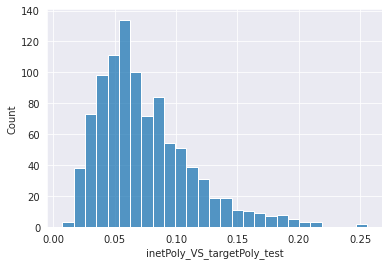

In [35]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

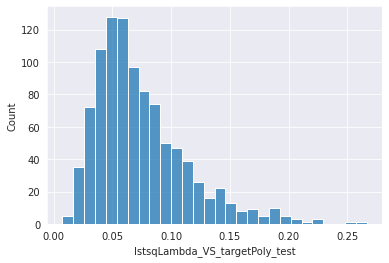

In [36]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50])


[(-30.0, 1.0)]

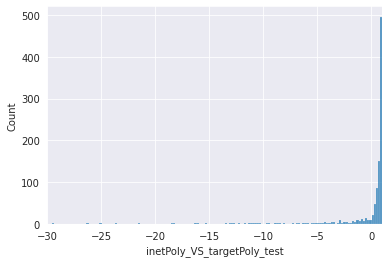

In [37]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

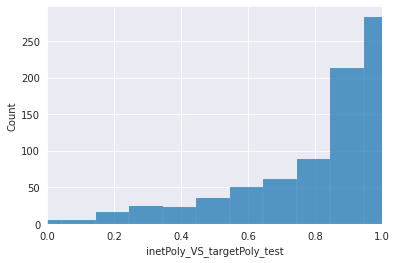

In [38]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

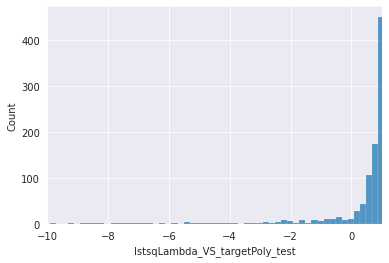

In [39]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

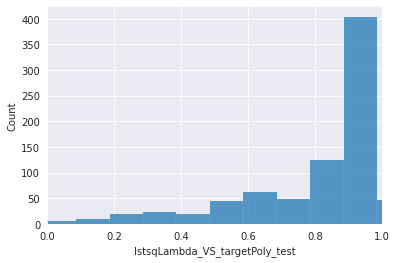

In [40]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

In [41]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [42]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [43]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [44]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [45]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [46]:
index = 5

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]

print('Target Poly:')
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Target Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Lambda Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_lambda, force_complete_poly_representation=True, round_digits=4)
print('I-Net Poly:')
print_polynomial_from_coefficients(polynomial_inet, round_digits=4)


Target Poly:


-0.0055*a**1.0 - 0.5873*a**2.0 - 0.937*a**3.0 - 0.067*a**4.0 + 0.4853*a**5.0 + 0.5663

LSTSQ Target Poly:


0.9744*a**1.0 - 4.0046*a**2.0 - 0.5213*a**3.0 + 5.8367*a**4.0 - 3.3517*a**5.0 + 0.5283

LSTSQ Lambda Poly:


0.9744*a**1.0 - 4.0046*a**2.0 - 0.5213*a**3.0 + 5.8367*a**4.0 - 3.3517*a**5.0 + 0.5283

I-Net Poly:


-0.137899994850159*a**1.0 - 1.03610002994537*a**2.0 - 0.465999990701675*a**3.0 + 0.0245999991893768*a**4.0 + 0.544300019741058*a**5.0 + 0.591000020503998

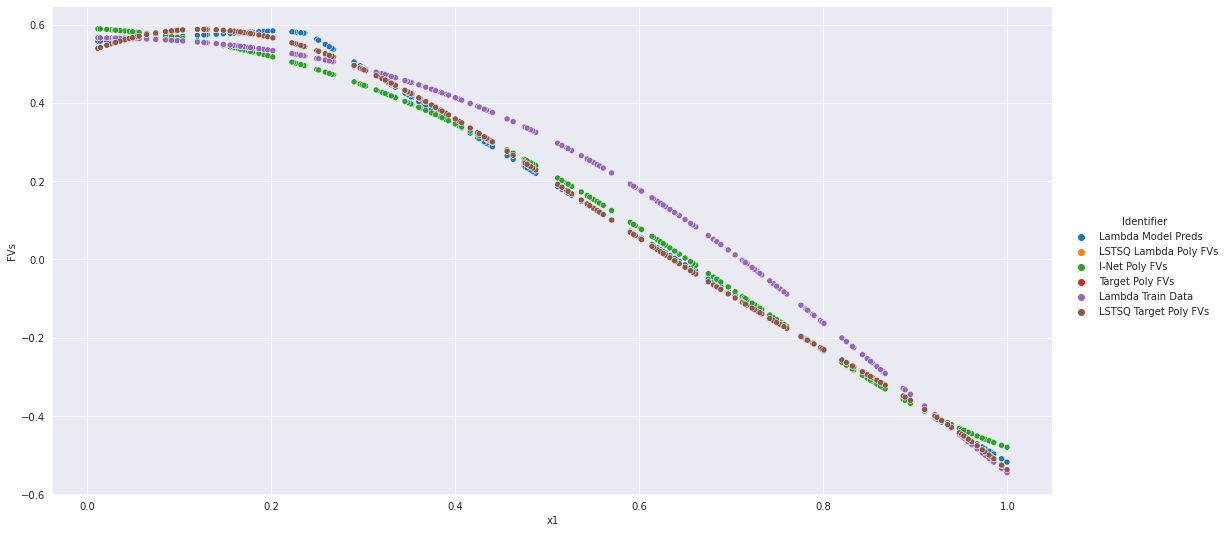

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.007615030968706597 | 0.9992605898617175 |   -    |  0.9744*a**1.0 - 4.0046*a**2.0 - 0.5213*a**3.0 +   |
|            vs.            |                      |                    |        |       5.8367*a**4.0 - 3.3517*a**5.0 + 0.5283       |
|  LSTSQ Lambda Preds Poly  |                      |                    |        |                                                    |
|                           |                      |                    |        |                                                    |
|       Lambda Preds        |  0.020940774354935

In [47]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

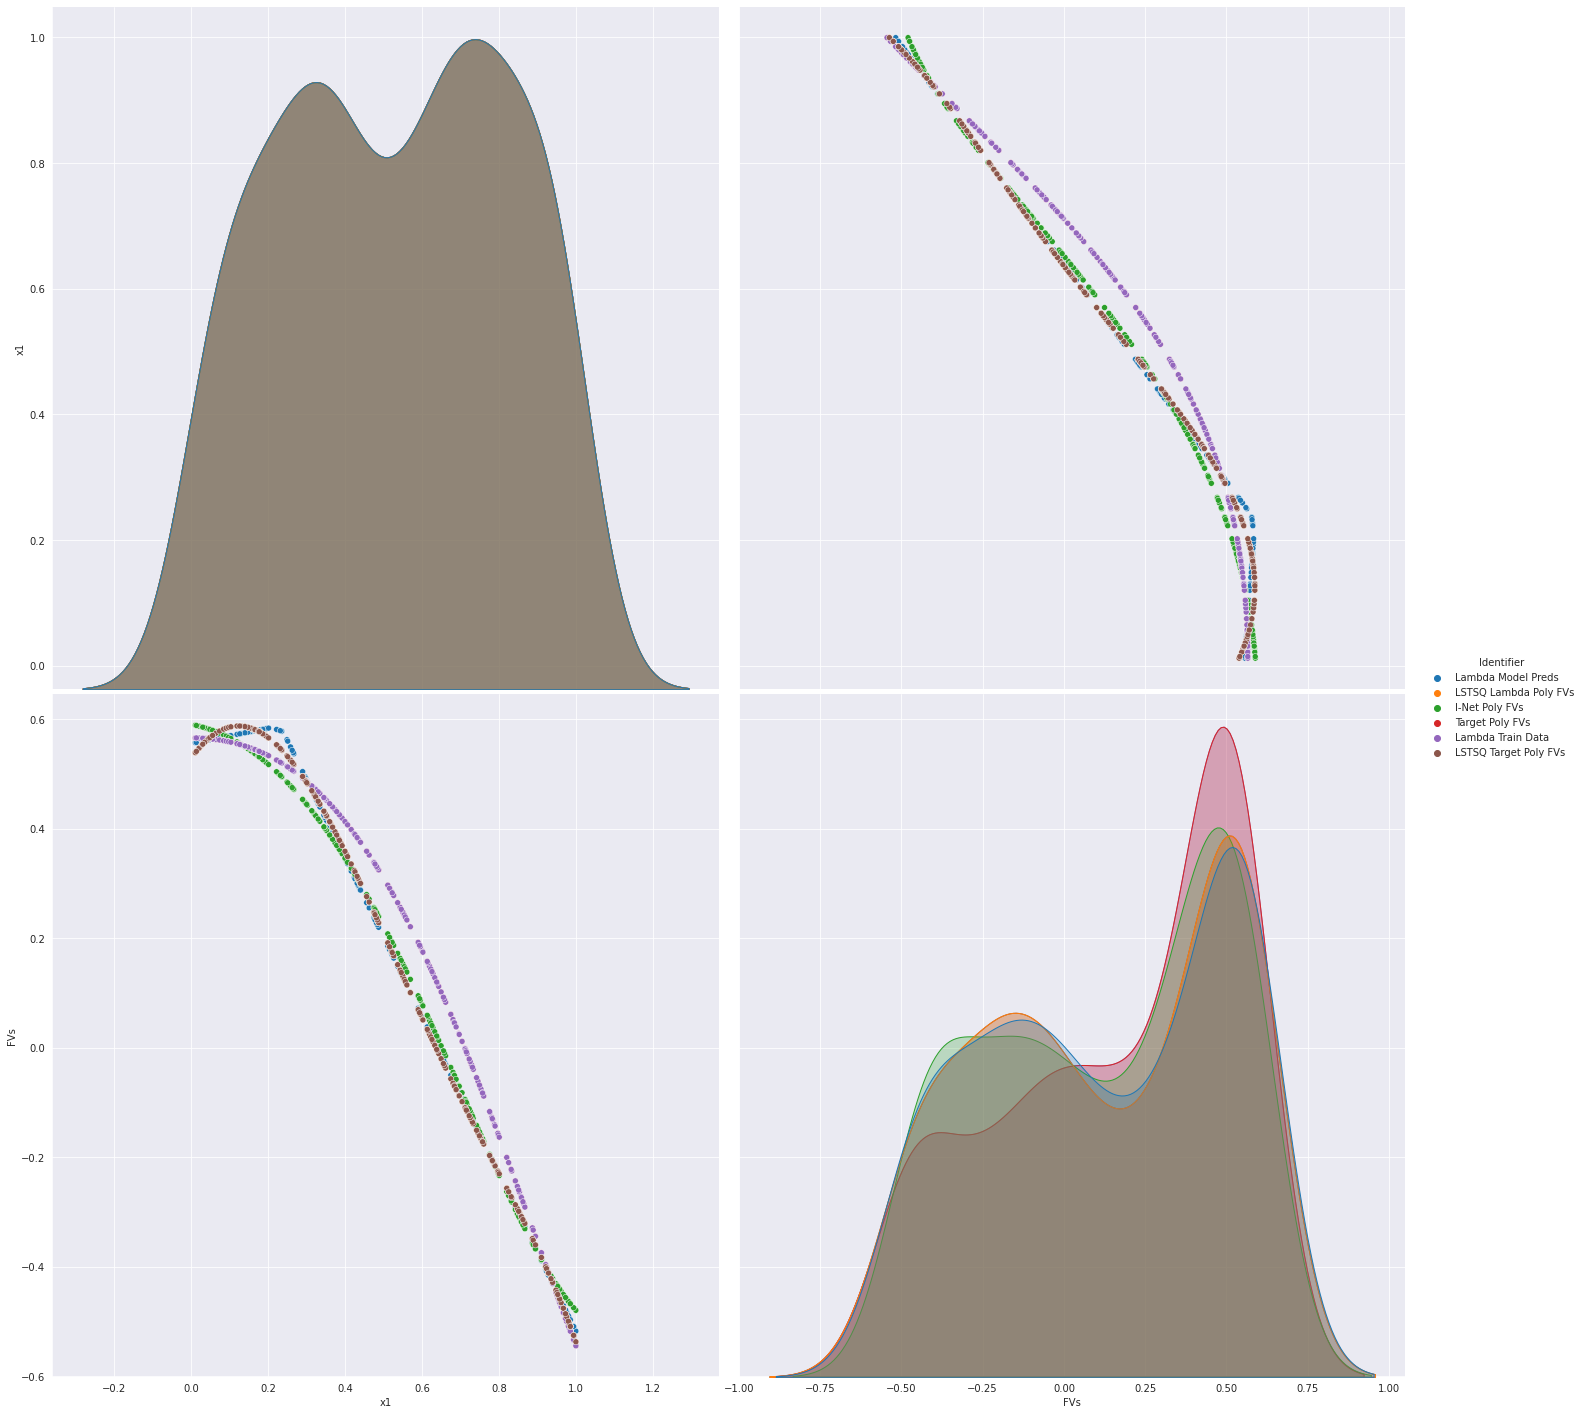

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.007615030968706597 | 0.9992605898617175 |   -    |  0.9744*a**1.0 - 4.0046*a**2.0 - 0.5213*a**3.0 +   |
|            vs.            |                      |                    |        |       5.8367*a**4.0 - 3.3517*a**5.0 + 0.5283       |
|  LSTSQ Lambda Preds Poly  |                      |                    |        |                                                    |
|                           |                      |                    |        |                                                    |
|       Lambda Preds        |  0.020940774354935

In [48]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

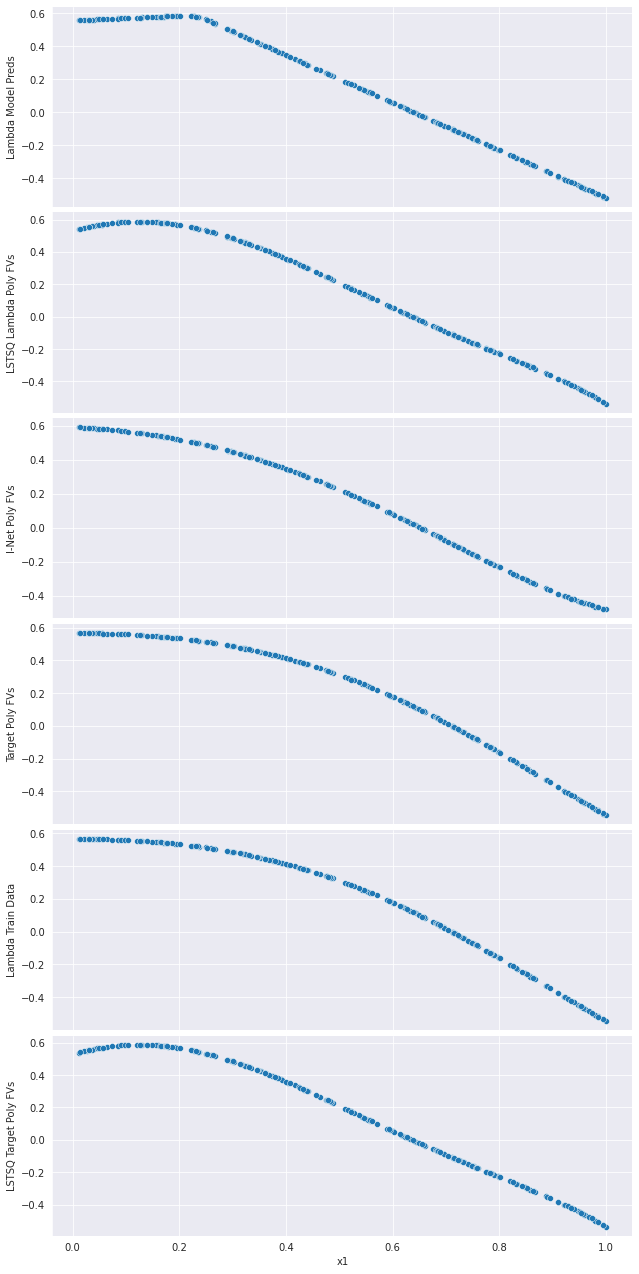

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.007615030968706597 | 0.9992605898617175 |   -    |  0.9744*a**1.0 - 4.0046*a**2.0 - 0.5213*a**3.0 +   |
|            vs.            |                      |                    |        |       5.8367*a**4.0 - 3.3517*a**5.0 + 0.5283       |
|  LSTSQ Lambda Preds Poly  |                      |                    |        |                                                    |
|                           |                      |                    |        |                                                    |
|       Lambda Preds        |  0.020940774354935

In [49]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [50]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [51]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

In [52]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.0374


In [53]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 6.3356


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [54]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [55]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.6153


In [56]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [57]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()